# Liquid Vapor Equilibrium

This notebook explores the calculation of equilibrium composition in liquid-vapor mixtures, a crucial concept in aerosol science and environmental studies. We utilize an activity coefficient model to understand how different volatile organic compounds distribute between the liquid and vapor phases. This analysis is particularly important for predicting aerosol behavior and understanding atmospheric processes.

In [1]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
# Importing necessary libraries
import matplotlib.pyplot as plt  # For creating plots and visualizations
import numpy as np  # For numerical operations

# For partitioning calculations in liquid-vapor equilibrium
from particula.equilibria import partitioning
from particula.particles.properties.organic_density_module import (
    get_organic_density_array,
)  # For calculating species density

## Setup the System

To simulate the liquid-vapor equilibrium, we define several key parameters:
- `c_star_j_dry`: Represents the volatility distribution of organic compounds in dry air, calculable from vapor pressure.
- `concentration_organic_matter`: The combined concentration of vapor and liquid organic matter in the system.
- `oxygen2carbon`: The ratio of oxygen to carbon in the organic compounds, crucial for characterizing their chemical nature.
- `molar_mass`: The molar mass of the organic compounds.

These parameters help us determine the density of organics in the system, a vital step in understanding their distribution between phases.


In [2]:
# Defining system parameters
c_star_j_dry = np.array(
    [1e-6, 1e-4, 1e-1, 1e2, 1e4], dtype=float
)  # Volatility distribution in ug/m3
# Total concentration in ug/m3
concentration_organic_matter = np.array([1, 5, 10, 15, 10], dtype=float)
oxygen2carbon = np.array([0.2, 0.3, 0.5, 0.4, 0.4])  # Oxygen to carbon ratios

molar_mass = np.array([200, 200, 200, 200, 200])  # Molar mass in g/mol
water_activity_desired = np.array([0.8])  # Desired water activity
molar_mass_ratio = 18.015 / np.array(molar_mass)  # Molar mass ratio

# Calculate the density of organic compounds
density = get_organic_density_array(
    molar_mass,
    oxygen2carbon,
    hydrogen2carbon=None,
    nitrogen2carbon=None,
)

## Calculate the Activity Coefficients

The next step involves calculating the activity coefficients, which are pivotal in determining how the organic compounds distribute between the liquid and vapor phases. We use the `partitioning.get_properties_for_liquid_vapor_equilibrium` function, a specialized tool that simplifies the process by returning only the essential properties: activity coefficients, mass fractions, and the two-phase *q* values for the alpha-beta equilibrium.


In [3]:
# Calculate the properties needed for liquid-vapor partitioning
gamma_organic_ab, mass_fraction_water_ab, q_ab = (
    partitioning.get_properties_for_liquid_vapor_partitioning(
        water_activity_desired=water_activity_desired,
        molar_mass=molar_mass,
        oxygen2carbon=oxygen2carbon,
        density=density,
    )
)

# The optimization the partition coefficients, i.e. the partitioning calculation
alpha_opt, beta_opt, system_opt, fit_result = (
    partitioning.liquid_vapor_partitioning(
        c_star_j_dry=c_star_j_dry,
        concentration_organic_matter=concentration_organic_matter,
        molar_mass=molar_mass,
        gamma_organic_ab=gamma_organic_ab,
        mass_fraction_water_ab=mass_fraction_water_ab,
        q_ab=q_ab,
        partition_coefficient_guess=None,
    )
)

print(f"mass in organic aerosol [ug/m3]: {system_opt[0]}")
print(f"mass in water [ug/3]: {system_opt[1]}")

mass in organic aerosol [ug/m3]: 24.216782218329037
mass in water [ug/3]: 9.407806893154259


## Activity Coefficients as a Function of Relative Humidity (f(RH))

The binary activity model's key feature is its interaction with water, particularly through relative humidity (RH). Here, we will calculate how the activity coefficients vary as a function of RH. This is done by iterating over a range of RH values and computing the corresponding activity coefficients, providing insights into how atmospheric humidity influences the equilibrium behavior of the system.

In [4]:
# Calculating activity coefficients across a range of RH values
# Range of water activity (RH/100)
water_activity_curve = np.linspace(0.01, 0.99, 50)
total_oa_concentration = np.empty([len(water_activity_curve), 1], dtype=float)
water_concentration = np.empty([len(water_activity_curve), 1], dtype=float)

for i, water_activity in enumerate(water_activity_curve):
    # Get properties for liquid-vapor partitioning at each RH value
    gamma_organic_ab, mass_fraction_water_ab, q_ab = (
        partitioning.get_properties_for_liquid_vapor_partitioning(
            water_activity_desired=water_activity,
            molar_mass=molar_mass,
            oxygen2carbon=oxygen2carbon,
            density=density,
        )
    )

    # Optimize the partition coefficients for each RH value
    alpha_opt, beta_opt, system_opt, fit_result = (
        partitioning.liquid_vapor_partitioning(
            c_star_j_dry=c_star_j_dry,
            concentration_organic_matter=concentration_organic_matter,
            molar_mass=molar_mass,
            gamma_organic_ab=gamma_organic_ab,
            mass_fraction_water_ab=mass_fraction_water_ab,
            q_ab=q_ab,
            partition_coefficient_guess=None,
        )
    )

    # Record the total organic and water concentration
    total_oa_concentration[i] = system_opt[0]
    water_concentration[i] = system_opt[1]

print("Calculation complete")

Calculation complete


## Plotting the Equilibrium Composition vs. Relative Humidity

(To be updated, current bug in q-alpha transfer)

Now that we have calculated the equilibrium composition for a range of RH values, we will visualize these results. The plot will show how the total organic aerosol concentration and the water concentration in the aerosol vary with changing RH. This visualization is crucial for understanding the dynamic behavior of aerosols in different atmospheric humidity conditions.

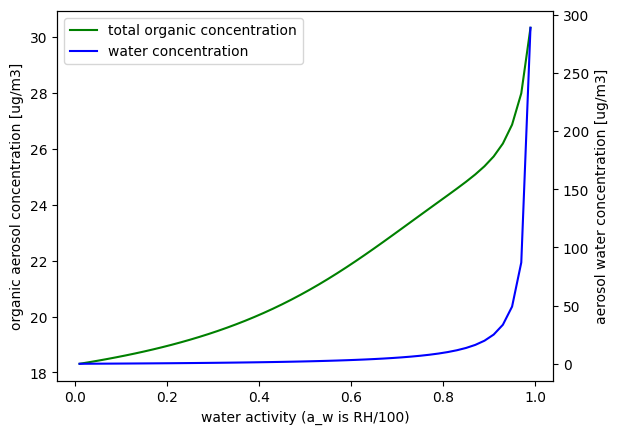

In [5]:
fig, ax = plt.subplots()
ax.plot(
    water_activity_curve,
    total_oa_concentration,
    label="total organic concentration",
    color="green",
)
aw = ax.twinx()
aw.plot(
    water_activity_curve,
    water_concentration,
    label="water concentration",
    color="blue",
)
plt.legend(loc="upper left")
ax.set_xlabel("water activity (a_w is RH/100)")

handles, labels = ax.get_legend_handles_labels()
aw_handles, aw_labels = aw.get_legend_handles_labels()
handles.extend(aw_handles)
labels.extend(aw_labels)
plt.legend(handles, labels, loc="upper left")

ax.set_ylabel("organic aerosol concentration [ug/m3]")
aw.set_ylabel("aerosol water concentration [ug/m3]")
plt.show()

## Summary

In this notebook, we have journeyed through the process of defining a liquid-vapor equilibrium system and employing the binary activity model to calculate activity coefficients as a function of relative humidity (RH). We then used these coefficients to determine the equilibrium composition of the liquid and vapor phases. Finally, the results were visualized to demonstrate the impact of RH on aerosol behavior, which is essential for understanding atmospheric aerosol dynamics and their environmental implications.
